# Best time to release review after tech event

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import datetime
import matplotlib.pyplot as plt

In [13]:
PATH_YT_METADATA = 'data/yt_metadata_en.jsonl'
ITEMS = ['iphone x', 'iphone 7', 'iphone 6', 'galaxy s9', 'galaxy note 9', 'galaxy fold']
RELEASE_DATES = {
    'iphone x': '2017-11-03',
    'iphone 7': '2016-09-16',
    'iphone 6': '2014-09-19',
    'galaxy s9': '2018-03-16',
    'galaxy note 9': '2018-08-24',
    'galaxy fold': '2019-02-01'
}

In [11]:
items_dfs = {k : [] for k in ITEMS}

In [12]:
# filter metadata
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date", "display_id", "tags"], inplace=True, axis=1)
    df_json = df_json[df_json['categories'].isin(['Science & Technology', 'Education', 'Entertainment'])]
    df_json.drop(["categories"], inplace=True, axis=1)
    for item in ITEMS:
        df_item = df_json[df_json['title'].str.lower().str.contains(item)]
        df_item["upload_date"] = pd.to_datetime(df_item["upload_date"])
        df_item = df_item[(df_item['upload_date'] >= datetime.datetime.strptime(RELEASE_DATES[item], '%Y-%m-%d') - datetime.timedelta(days=180)) & (df_item['upload_date'] <= datetime.datetime.strptime(RELEASE_DATES[item], '%Y-%m-%d') + datetime.timedelta(days=180))]
        if len(df_item) > 0:
            items_dfs[item].append(df_item)
# yt_metadata.to_pickle(PATH_YT_TECH_METADATA,compression='gzip')

Loading data: 730it [08:59,  1.35it/s]                               


In [13]:
items_dfs = {k : pd.concat(v) for k, v in items_dfs.items()}

In [14]:
import pickle
with open('data/yt_tech_metadata.pickle', 'wb') as f:
    pickle.dump(items_dfs, f)

In [15]:
for item in ITEMS:
    print(len(items_dfs[item]))

5388
4456
3856
3882
2293
596


In [2]:
def get_avg_views(df):
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df["upload_date"] = df["upload_date"].dt.date

    # convert 'view_count' to int
    df["view_count"] = df["view_count"].astype(int)

    # keep only 'view_count' and 'upload_date'
    df = df[["view_count", "upload_date"]]
    df = df.groupby("upload_date").sum()
    
    return df

In [3]:
def plot_views_per_day(df, item):
    plt.figure(figsize=(20,10))
    plt.bar(df.index, df["view_count"])
    plt.xlabel("Date")
    plt.ylabel("View Count")
    plt.title("{item} View Count Over Time".format(item=item))
    plt.show()

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from gensim import corpora, models
import gensim
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')

In [5]:
def tf_idf(tokens):
    """
    Given a list of tokens, compute the tf-idf coefficient for each token.
    :param tokens: list of titles split into tokens
    :return: dictionary of tf-idf coefficients
    """
    # create dictionary
    dictionary = corpora.Dictionary(tokens)
    
    # create corpus
    corpus = [dictionary.doc2bow(text) for text in tokens]
    
    # create tf-idf model
    tfidf = models.TfidfModel(corpus)
    
    # get tf-idf coefficients
    tfidf_weights = {}
    for doc in corpus:
        for id, weight in tfidf[doc]:
            tfidf_weights[dictionary[id]] = weight
    
    return tfidf_weights

In [6]:
def get_tf_idf_score(tf_idf_scores, words):
    """
    Given a dictionary of tf-idf scores and a list of words, compute the average tf-idf score for the list of words.
    :param tf_idf_scores: dictionary of tf-idf scores
    :param words: list of words
    :return: average tf-idf score for the list of words
    """
    score = 0
    for word in words:
        score += tf_idf_scores.get(word, 0)

    return score / len(words)

In [7]:
def score_per_day(df, item, release_date):
    """
    Given a product name, fetches the df for videos with titles containing the name of the product
    that were uploaded within 6 months of the product's release date and computes the total view count,
    total likes total dislikes and number of videos per day.
    :param item: product name
    :param df: dataframe of videos with titles containing the name of the product
    :return: dataframe of total view count, total likes total dislikes and number of videos per day
    """

    # filter out titles that do not contain the product name
    df = df[df["title"].str.lower().str.contains(item)]
    
    # convert 'view_count' to int
    df["view_count"] = df["view_count"].astype(int)

    # convert 'upload_date' to datetime
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df["upload_date"] = df["upload_date"].dt.date

    # keep only rows that were uploaded within 3 months of the product's release date
    df = df[(df["upload_date"] >= release_date - datetime.timedelta(days=90)) & (df["upload_date"] <= release_date + datetime.timedelta(days=90))]

    # keep only 'view_count', 'upload_date', 'likes', 'dislikes', 'title'
    df = df[["view_count", "upload_date", "like_count", "dislike_count", "title"]]

    # group by 'upload_date'
    df = df.groupby("upload_date")

    # compute total view count, total like_count, total dislike_count and number of videos per day
    df = df.agg({"view_count": "sum", "like_count": "sum", "dislike_count": "sum", "title": "count"})

    return df

In [8]:
import matplotlib.pyplot as plt
def plot_scores(scores_df, release_date, product_name):
    """
    Given a dataframe of view count, like count, dislike count and number of videos per day,
    plots the view count, like count, dislike count and number of videos per day over time.
    :param scores_df: dataframe of view count, like count, dislike count and number of videos per day
    :return: None
    """

    # plot the 4 curves in 4 subplots as bar graphs and for each subplot put a vertical dotted line at the release date
    fig, axs = plt.subplots(5, figsize=(20, 20))
    axs[0].bar(scores_df.index, scores_df["view_count"])
    axs[0].set_title("View Count Over Time")
    axs[0].axvline(x=release_date, color="red", linestyle="--")

    axs[1].bar(scores_df.index, scores_df["like_count"])
    axs[1].set_title("Like Count Over Time")
    axs[1].axvline(x=release_date, color="red", linestyle="--")

    axs[2].bar(scores_df.index, scores_df["dislike_count"])
    axs[2].set_title("Dislike Count Over Time")
    axs[2].axvline(x=release_date, color="red", linestyle="--")
    
    axs[3].bar(scores_df.index, scores_df["title"])
    axs[3].set_title("Number of Videos Over Time")
    axs[3].axvline(x=release_date, color="red", linestyle="--")

    axs[4].bar(scores_df.index, scores_df["view_count"] / scores_df["title"])
    axs[4].set_title("Average Views Per Video Over Time")
    axs[4].axvline(x=release_date, color="red", linestyle="--")
    

    # give a big title to the entire figure
    fig.suptitle("Scores Over Time for {product_name}".format(product_name=product_name), fontsize=30)
    plt.show()


In [9]:
def get_lda_topics(df, num_topics, num_words):
    # tokenize words
    tokenizer = RegexpTokenizer(r'\w+')
    df["tokens"] = df["title"].apply(tokenizer.tokenize)

    # convert to lowercase
    df["tokens"] = df["tokens"].apply(lambda x: [word.lower() for word in x])
    
    # remove stop words
    stop_words = stopwords.words('english')
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in stop_words])
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    df["tokens"] = df["tokens"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # remove words that appear only once
    all_tokens = sum(df["tokens"], [])
    tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in tokens_once])

    # remove the token 'iphone'
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word != "iphone"])

    # remove one character tokens
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if len(word) > 2])
    
    # create dictionary and corpus
    dictionary = corpora.Dictionary(df["tokens"])
    corpus = [dictionary.doc2bow(text) for text in df["tokens"]]
    
    # create LDA model
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    
    # print topics
    print("LDA Topics:")
    for topic in lda.print_topics(num_words=num_words):
        print(topic)
    
    # visualize topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
    return vis

In [10]:
import pickle
import pandas as pd
import datetime
with open('data/yt_tech_metadata.pickle', 'rb') as f:
    items_dfs = pickle.load(f)

In [14]:
df = score_per_day(items_dfs['iphone x'], 'iphone x', datetime.datetime.strptime(RELEASE_DATES['iphone x'], '%Y-%m-%d').date())

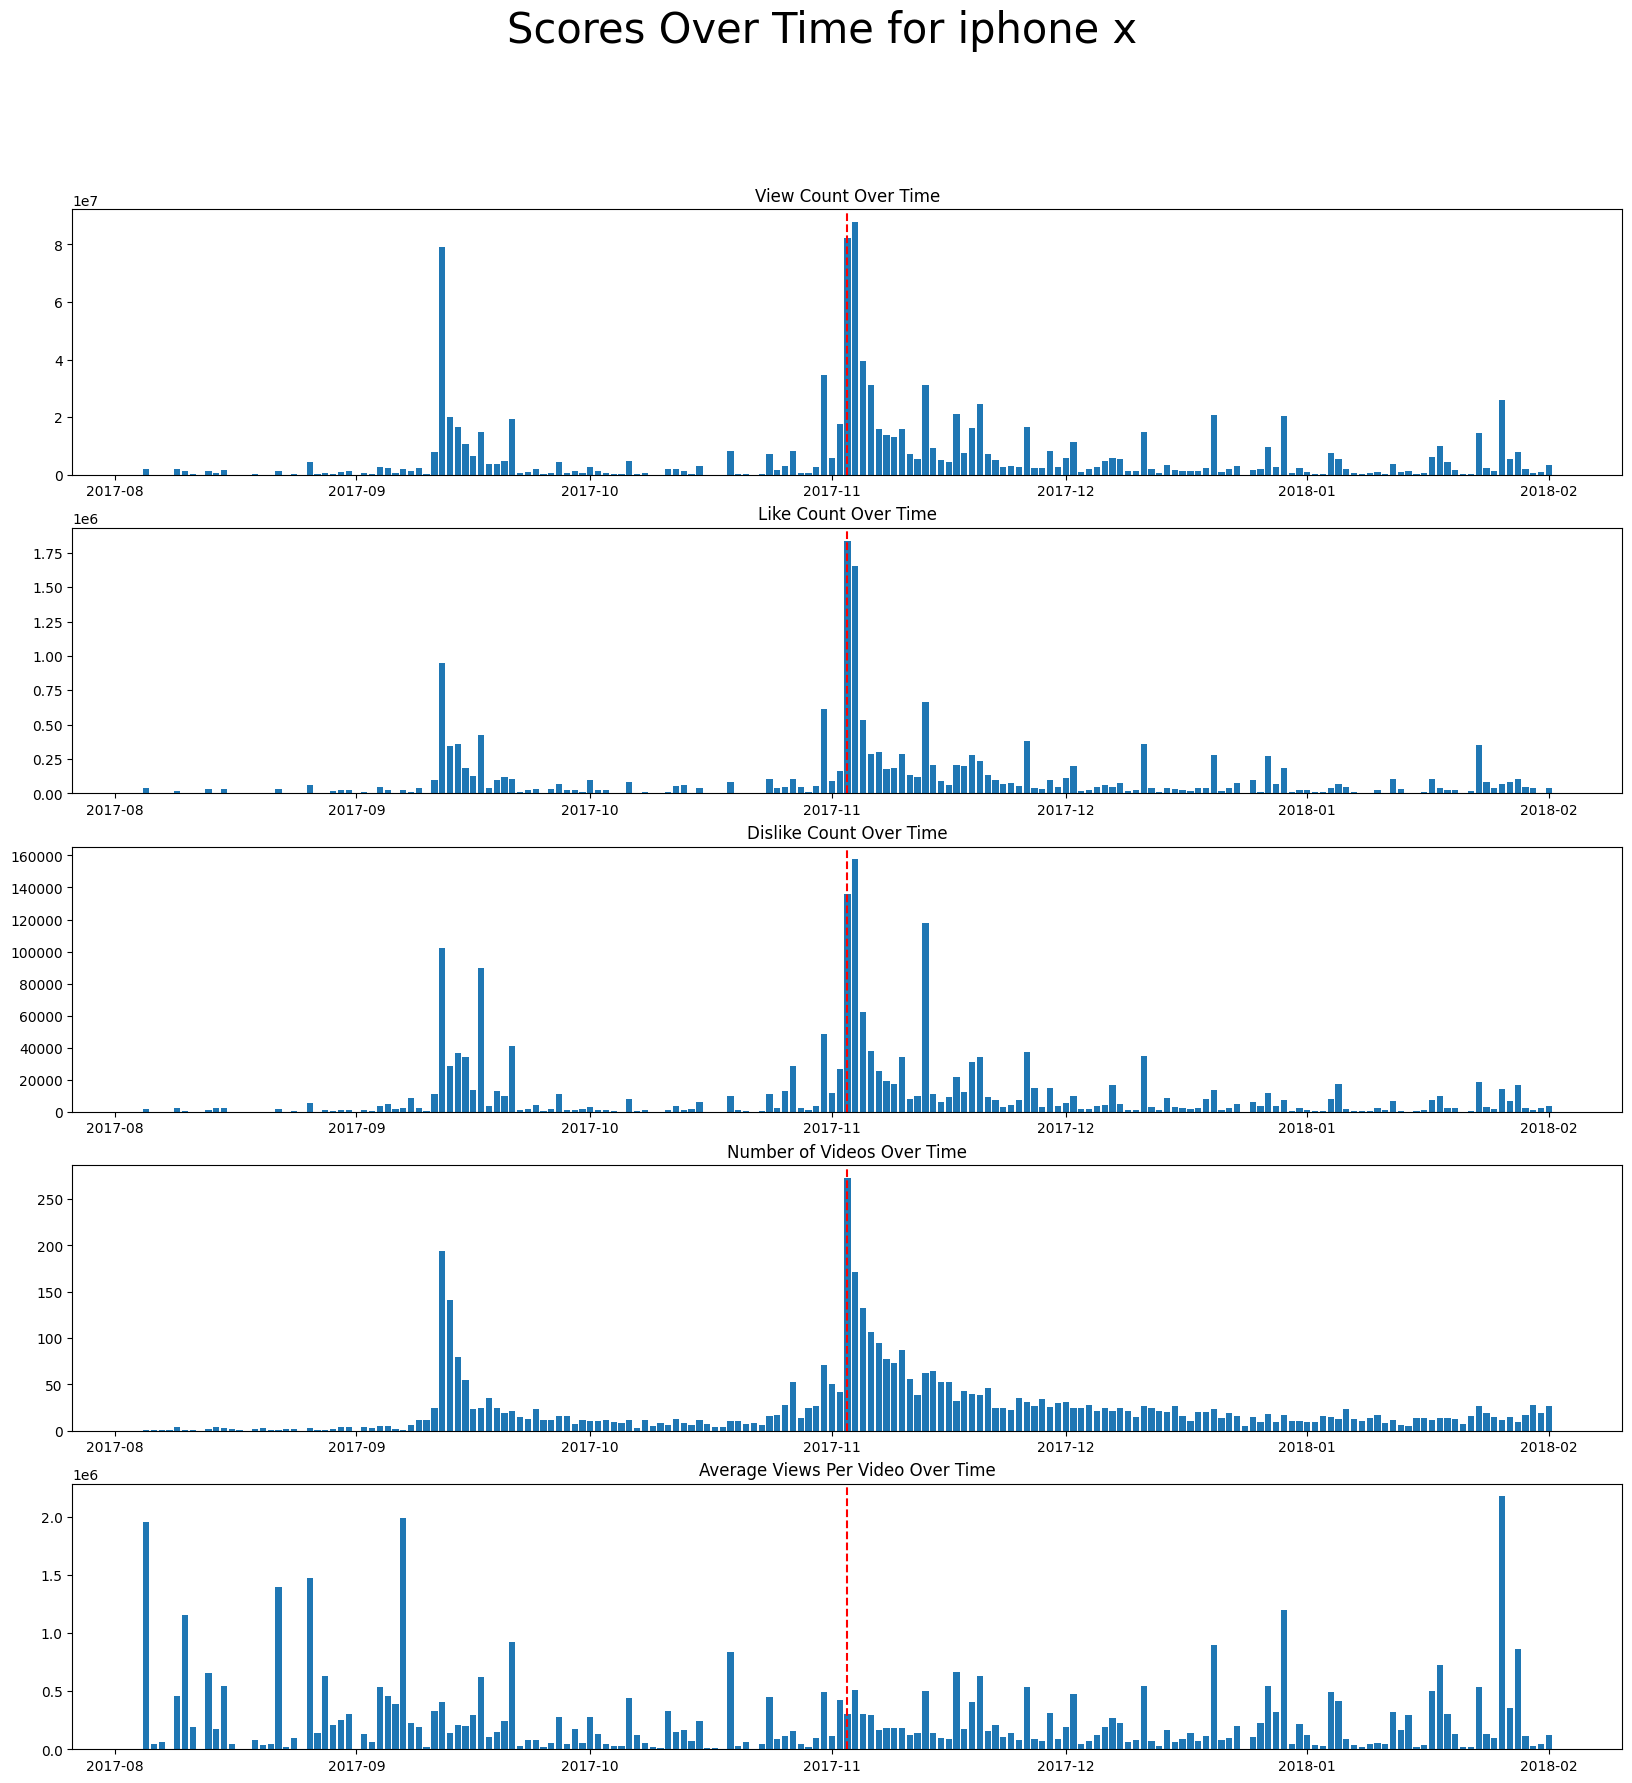

In [15]:
# convert RELEASE_DATES['iphone x'] to datetime
release_date = datetime.datetime.strptime(RELEASE_DATES['iphone x'], '%Y-%m-%d').date()
plot_scores(df, release_date, 'iphone x')

In [16]:
iphone_df = items_dfs['iphone x']
iphone_df["upload_date"] = pd.to_datetime(iphone_df["upload_date"])

# convert upload_date to date
iphone_df["upload_date"] = iphone_df["upload_date"].dt.date

pre_release = iphone_df[(iphone_df["upload_date"] <= release_date - datetime.timedelta(days=30))]
release = iphone_df[(iphone_df["upload_date"] >= release_date - datetime.timedelta(days=30)) & (iphone_df["upload_date"] <= release_date + datetime.timedelta(days=30))]
post_release = iphone_df[(iphone_df["upload_date"] >= release_date + datetime.timedelta(days=30))]

In [45]:
get_lda_topics(pre_release, 3, 10)

LDA Topics:
(0, '0.080*"apple" + 0.023*"face" + 0.023*"plus" + 0.019*"know" + 0.019*"need" + 0.016*"everything" + 0.016*"event" + 0.015*"samsung" + 0.015*"feature" + 0.015*"galaxy"')
(1, '0.048*"new" + 0.038*"apple" + 0.022*"feature" + 0.016*"android" + 0.014*"best" + 0.013*"get" + 0.013*"review" + 0.013*"tech" + 0.012*"2017" + 0.012*"note"')
(2, '0.070*"apple" + 0.039*"plus" + 0.031*"buy" + 0.018*"first" + 0.017*"galaxy" + 0.016*"feature" + 0.016*"launch" + 0.015*"hand" + 0.015*"note" + 0.014*"price"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.082282 -0.015365       1        1  39.599078
0      0.055885 -0.056624       2        1  31.371740
1      0.026396  0.071989       3        1  29.029183, topic_info=          Term       Freq      Total Category  logprob  loglift
27         new  65.000000  65.000000  Default  30.0000  30.0000
42        need  24.000000  24.000000  Default  29.0000  29.0000
76         buy  51.000000  51.000000  Default  28.0000  28.0000
47       first  25.000000  25.000000  Default  27.0000  27.0000
41  everything  20.000000  20.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
24       price   6.708593  31.426732   Topic3  -4.9794  -0.3074
5      samsung   6.390683  29.435737   Topic3  -5.0280  -0.2905
63        plus   7.346919  84.021577   Topic3  -4.8885  -1.1999
87       phone   6.032869  29.894475   Topic3  -5.0856  -0.3636
76         buy   5.823244  51.060517   Topic3  -5.1210  -0.9343

[208 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
29        1  0.243030     2017
29        2  0.425303     2017
29        3  0.364545     2017
309       1  0.768462     64gb
239       2  0.829723      a11
...     ...       ...      ...
287       1  0.188496     year
287       3  0.753986     year
444       3  0.752536    young
8         2  0.320539  youtube
8         3  0.641078  youtube

[293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [44]:
get_lda_topics(release, 3, 10)

LDA Topics:
(0, '0.055*"unboxing" + 0.046*"review" + 0.040*"apple" + 0.022*"first" + 0.019*"impression" + 0.014*"samsung" + 0.013*"galaxy" + 0.013*"2017" + 0.012*"plus" + 0.010*"best"')
(1, '0.028*"unboxing" + 0.021*"test" + 0.020*"apple" + 0.020*"camera" + 0.019*"review" + 0.019*"phone" + 0.019*"new" + 0.018*"face" + 0.016*"plus" + 0.016*"comparison"')
(2, '0.030*"case" + 0.029*"face" + 0.024*"test" + 0.023*"review" + 0.021*"apple" + 0.016*"pixel" + 0.015*"camera" + 0.013*"get" + 0.012*"speed" + 0.011*"new"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.131587 -0.034182       1        1  35.420116
2      0.098214 -0.086962       2        1  33.614574
1      0.033374  0.121144       3        1  30.965310, topic_info=           Term        Freq       Total Category  logprob  loglift
20     unboxing  287.000000  287.000000  Default  30.0000  30.0000
9          face  150.000000  150.000000  Default  29.0000  29.0000
6        camera  109.000000  109.000000  Default  28.0000  28.0000
65   impression   79.000000   79.000000  Default  27.0000  27.0000
16         test  149.000000  149.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
36         case   27.519086  157.570191   Topic3  -4.6815  -0.5727
50         live   21.034708   62.241567   Topic3  -4.9502   0.0875
72         2017   21.017296   78.632503   Topic3  -4.9510  -0.1471
3           top   17.403545   38.477848   Topic3  -5.1397   0.3789
101      silver   17.209884   35.598018   Topic3  -5.1509   0.4455

[226 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
133       1  0.088676       100
133       2  0.886756       100
133       3  0.088676       100
591       2  0.916264     10000
72        1  0.559565      2017
...     ...       ...       ...
46        1  0.732242  wireless
46        2  0.122040  wireless
46        3  0.152551  wireless
79        2  0.110530   without
79        3  0.884240   without

[351 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [43]:
get_lda_topics(post_release, 3, 10)

LDA Topics:
(0, '0.043*"galaxy" + 0.035*"samsung" + 0.030*"apple" + 0.029*"plus" + 0.024*"review" + 0.019*"rom" + 0.019*"pixel" + 0.015*"comparison" + 0.015*"android" + 0.012*"2018"')
(1, '0.039*"update" + 0.027*"link" + 0.022*"later" + 0.022*"month" + 0.020*"first" + 0.019*"unboxing" + 0.019*"apple" + 0.017*"review" + 0.017*"new" + 0.016*"rainie"')
(2, '0.047*"2018" + 0.030*"apps" + 0.026*"best" + 0.024*"app" + 0.023*"review" + 0.020*"apple" + 0.020*"android" + 0.018*"update" + 0.015*"galaxy" + 0.015*"switching"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.106458  0.086817       1        1  38.731565
0      0.030358 -0.126337       2        1  34.306497
1     -0.136816  0.039520       3        1  26.961938, topic_info=        Term        Freq       Total Category  logprob  loglift
449     apps  113.000000  113.000000  Default  30.0000  30.0000
388     link   72.000000   72.000000  Default  29.0000  29.0000
116     2018  226.000000  226.000000  Default  28.0000  28.0000
66    update  183.000000  183.000000  Default  27.0000  27.0000
306      rom   65.000000   65.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
83       red   14.272263   19.633181   Topic3  -5.1864   0.9918
51      test   21.784868   87.273168   Topic3  -4.7635  -0.0771
20   samsung   24.119071  179.384707   Topic3  -4.6617  -0.6958
78      best   18.515112  115.287213   Topic3  -4.9261  -0.5181
17    galaxy   18.591619  214.667090   Topic3  -4.9220  -1.1356

[200 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1044      1  0.945318    1080p
116       1  0.769768     2018
116       2  0.176958     2018
116       3  0.053087     2018
1037      1  0.878768     64gb
...     ...       ...      ...
311       2  0.080408  zenfone
311       3  0.040204  zenfone
1055      1  0.054275   接電視玩遊戲
1055      2  0.081412   接電視玩遊戲
1055      3  0.868398   接電視玩遊戲

[368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])